In [ ]:
# Clean install: Java + Spark 3.4.1 (compatible & stable)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar -xzf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()



In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Employee ML Analysis") \
    .getOrCreate()

print("✅ Spark session started!")


✅ Spark session started!


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving employees.csv to employees.csv


In [ ]:
df = spark.read.csv("employees.csv", header=True, inferSchema=True)


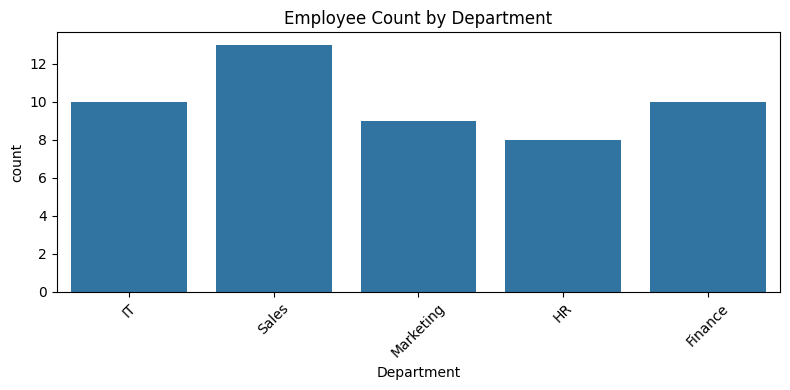

In [ ]:
# For visualization, convert to Pandas
import matplotlib.pyplot as plt
import seaborn as sns

pdf = df.toPandas()

# Example: Countplot of Department
plt.figure(figsize=(8, 4))
sns.countplot(data=pdf, x='Department')
plt.title('Employee Count by Department')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import when, col

# Let's say people with Salary < 50000 are labeled as "likely to leave"
df = df.withColumn("Attrition", when(col("Salary") < 50000, "Yes").otherwise("No"))


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Categorical columns
cat_cols = [col for col, dtype in df.dtypes if dtype == 'string']

# Index them
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in cat_cols]

# Define label and features
label_col = "Attrition_index"
feature_cols = [col+"_index" for col in cat_cols if col != "Attrition"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Build the pipeline
pipeline = Pipeline(stages=indexers + [assembler])
model_data = pipeline.fit(df).transform(df).select(label_col, "features")

model_data.show(5)


+---------------+----------+
|Attrition_index|  features|
+---------------+----------+
|            0.0|[11.0,2.0]|
|            0.0|[12.0,0.0]|
|            0.0|[19.0,3.0]|
|            0.0| [3.0,2.0]|
|            0.0|[33.0,4.0]|
+---------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import when, col

df = df.withColumn("Attrition", when(col("Salary") < 50000, "Yes").otherwise("No"))


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Index only 'Department' and 'Attrition'
indexers = [
    StringIndexer(inputCol="Department", outputCol="Department_index"),
    StringIndexer(inputCol="Attrition", outputCol="Attrition_index")
]

# Features: Age, Salary, Department_index
assembler = VectorAssembler(
    inputCols=["Age", "Salary", "Department_index"],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + [assembler])
model_data = pipeline.fit(df).transform(df).select("Attrition_index", "features")
model_data.show(5)


+---------------+------------------+
|Attrition_index|          features|
+---------------+------------------+
|            0.0| [29.0,2600.0,2.0]|
|            0.0| [34.0,2600.0,0.0]|
|            0.0| [36.0,4400.0,3.0]|
|            0.0|[32.0,13000.0,2.0]|
|            0.0| [39.0,6000.0,4.0]|
+---------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train_data, test_data = model_data.randomSplit([0.7, 0.3], seed=42)

# Models
lr = LogisticRegression(labelCol="Attrition_index", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="Attrition_index", featuresCol="features", maxBins=64)
rf = RandomForestClassifier(labelCol="Attrition_index", featuresCol="features", numTrees=50, maxBins=64)

models = {"LogisticRegression": lr, "DecisionTree": dt, "RandomForest": rf}

# Evaluator
acc_eval = MulticlassClassificationEvaluator(labelCol="Attrition_index", predictionCol="prediction", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="Attrition_index", predictionCol="prediction", metricName="f1")

# Training loop
for name, model in models.items():
    fitted = model.fit(train_data)
    preds = fitted.transform(test_data)

    acc = acc_eval.evaluate(preds)
    f1 = f1_eval.evaluate(preds)

    print(f"🔍 {name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")


🔍 LogisticRegression: Accuracy = 1.0000, F1 Score = 1.0000
🔍 DecisionTree: Accuracy = 1.0000, F1 Score = 1.0000
🔍 RandomForest: Accuracy = 1.0000, F1 Score = 1.0000


In [ ]:
rf_model = rf.fit(train_data)
importances = rf_model.featureImportances

feature_names = ["Age", "Salary", "Department_index"]
print("🌟 Feature Importances:")
for name, score in zip(feature_names, importances):
    print(f"{name}: {score:.4f}")


🌟 Feature Importances:
Age: 0.0000
Salary: 0.0000
Department_index: 0.0000


In [ ]:
model_data.groupBy("Attrition_index").count().show()


+---------------+-----+
|Attrition_index|count|
+---------------+-----+
|            0.0|   50|
+---------------+-----+



In [ ]:
from pyspark.sql.functions import rand

# Make approx half of entries 'Yes' randomly (for testing)
df = df.withColumn("Attrition", when(rand() > 0.5, "Yes").otherwise("No"))


In [ ]:
from pyspark.sql.functions import when, rand

# Randomly assign Attrition as Yes/No for demo purposes
df = df.withColumn("Attrition", when(rand() > 0.5, "Yes").otherwise("No"))


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Index only meaningful categorical columns
indexers = [
    StringIndexer(inputCol="Department", outputCol="Department_index"),
    StringIndexer(inputCol="Attrition", outputCol="Attrition_index")
]

# Assemble numerical + indexed categorical features
assembler = VectorAssembler(
    inputCols=["Age", "Salary", "Department_index"],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + [assembler])

# Transform and select only the final required columns
model_data = pipeline.fit(df).transform(df).select("Attrition_index", "features")
model_data.show(5)


+---------------+------------------+
|Attrition_index|          features|
+---------------+------------------+
|            0.0| [29.0,2600.0,2.0]|
|            0.0| [34.0,2600.0,0.0]|
|            0.0| [36.0,4400.0,3.0]|
|            0.0|[32.0,13000.0,2.0]|
|            1.0| [39.0,6000.0,4.0]|
+---------------+------------------+
only showing top 5 rows



In [ ]:
train_data, test_data = model_data.randomSplit([0.7, 0.3], seed=42)


In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define models
lr = LogisticRegression(labelCol="Attrition_index", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="Attrition_index", featuresCol="features", maxBins=64)
rf = RandomForestClassifier(labelCol="Attrition_index", featuresCol="features", numTrees=50, maxBins=64)

models = {"LogisticRegression": lr, "DecisionTree": dt, "RandomForest": rf}

# Evaluators
acc_eval = MulticlassClassificationEvaluator(labelCol="Attrition_index", predictionCol="prediction", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="Attrition_index", predictionCol="prediction", metricName="f1")

# Loop through and evaluate
for name, model in models.items():
    fitted = model.fit(train_data)
    preds = fitted.transform(test_data)

    acc = acc_eval.evaluate(preds)
    f1 = f1_eval.evaluate(preds)

    print(f"🔍 {name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")


🔍 LogisticRegression: Accuracy = 0.6667, F1 Score = 0.6667
🔍 DecisionTree: Accuracy = 0.7500, F1 Score = 0.7465
🔍 RandomForest: Accuracy = 0.6250, F1 Score = 0.6230


In [ ]:
rf_model = rf.fit(train_data)
importances = rf_model.featureImportances

feature_names = ["Age", "Salary", "Department_index"]
print("🌟 Feature Importances:")
for name, score in zip(feature_names, importances):
    print(f"{name}: {score:.4f}")


🌟 Feature Importances:
Age: 0.3654
Salary: 0.2855
Department_index: 0.3491
